In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx


from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from qiskit.optimization.ising import max_cut

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

### Max Cut

In [320]:
w = np.zeros([6,6])
for i in range(5):
    w[i, i+1] = 1
    w[i+1, i] = 1
w[0,5] = 1
w[5,0] = 1
w #ajacency matrix

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

In [321]:
qubitOp, offset = max_cut.get_operator(w)# get the qubit operator given the graph
qubitOp.print_details()

'IIIIZZ\t(0.5+0j)\nIIIZZI\t(0.5+0j)\nIIZZII\t(0.5+0j)\nIZZIII\t(0.5+0j)\nZIIIIZ\t(0.5+0j)\nZZIIII\t(0.5+0j)\n'

#### QAOA

In [14]:
adam = ADAM(maxiter=1000)#optimizer
qaoa = QAOA(qubitOp, adam)#QAOA solver

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
result = qaoa.run(quantum_instance)
print('solution:', common.sample_most_likely(result['eigvecs'][0]))

#### From Scratch

In [29]:
class circuits:
    def __init__(self, qbits, cbits):
        self.qbits = qbits
        self.cbits = cbits
        self.circ = QuantumCircuit(qbits, cbits)
        for i in range(qbits):
            self.circ.h(i)
    
    def beta_gate(self, beta, qbit):
        self.circ.u3(2*beta, -pi/2, pi/2, qbit)
        
    def gamma_gate(self, gamma, qbit0, qbit1):
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.cnot(qbit1, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(gamma/2, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(-gamma/2, qbit0)
        self.circ.cnot(qbit1, qbit0)
        
    def measure(self):
        for i in range(self.qbits):
            self.circ.measure(i,i)

In [33]:
class maxcut:
    def __init__(self, G):
        self.G = G
        self.n = len(G)
#         self.G = nx.Graph()
#         self.G.add_nodes_from(np.arange(0,n,1))
#         self.elist = elist
#         # tuple is (i,j,weight) where (i,j) is the edge
#         self.G.add_edges_from(elist)

    def draw(self):
        colors = ['w' for node in self.G.nodes()]
        pos = nx.spring_layout(self.G)
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        plt.show()
        
    def build_circuit(self, depth, beta, gamma):
        self.circuit = circuits(self.n, self.n)
        for i in range(depth):
            for node in range(self.n):
                self.circuit.beta_gate(beta[i],node)
            for (node0, node1) in self.G.edges:
                self.circuit.gamma_gate(gamma[i], node0, node1)
        self.circuit.measure()
        
    def solve(self, sims):
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit.circ, backend_sim, shots=sims)

        # Grab the results from the job.
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit.circ)
        return counts

[[0 1 1 1 0]
 [1 0 0 1 1]
 [1 0 0 0 1]
 [1 1 0 0 0]
 [0 1 1 0 0]]


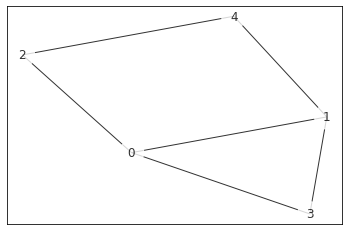

In [585]:
G = nx.Graph([(0,1),(0,2),(0,3),(1,3),(1,4),(2,4)])
edges = len(G)
A = nx.adjacency_matrix(G)
A = np.array(A.todense())
print(A)

#mc = maxcut(edges, [[0,1], [1,2], [1,3], [2,3]])
mc = maxcut(G)
mc.draw()

In [6]:
mc.build_circuit(depth = 2, beta = [0,0.3], gamma = [2,0])

In [621]:
#mc.circuit.circ.draw(output='mpl')

In [623]:
mc.solve(sims=10000)

{'0010': 1298,
 '1111': 455,
 '1101': 1310,
 '0001': 1580,
 '1100': 729,
 '1110': 1537,
 '0000': 456,
 '1010': 445,
 '0100': 29,
 '0110': 467,
 '1011': 33,
 '0011': 708,
 '0101': 436,
 '0111': 27,
 '1001': 460,
 '1000': 30}

In [586]:
#Thingy for binary thingy
s = list("{0:0eb}")
s[4] = str(edges)
binlist="".join(s)

energy = np.zeros(2**edges, dtype=int)
for k in range(0,2**edges):
    y = np.array([int(x) for x in binlist.format(k)]) #btw we gotta change this part manually when we have larger graph
    energy[k] = int(np.sum(np.outer(y,(1-y)) * A))

print(energy)

[0 2 2 4 2 2 4 4 3 3 3 3 5 3 5 3 3 5 3 5 3 3 3 3 4 4 2 2 4 2 2 0]


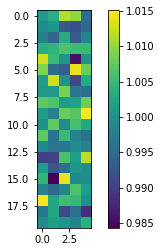

[array([[-1.90e-03, -3.10e-03, -1.87e-02, -1.80e-02, -1.00e-03],
       [-1.75e-03, -4.55e-03, -4.20e-03, -8.45e-03,  1.50e-03],
       [ 2.20e-03,  1.95e-03,  6.85e-03,  6.70e-03,  5.35e-03],
       [ 7.60e-03,  5.25e-03, -1.50e-03, -3.70e-03,  9.50e-04],
       [ 2.80e-03, -4.60e-03, -6.55e-03,  4.20e-03,  1.60e-03],
       [-5.65e-03,  3.90e-03,  5.00e-05,  2.60e-03,  1.55e-03],
       [-4.20e-03,  2.80e-03,  7.70e-03, -8.75e-03, -6.25e-03],
       [ 2.95e-03, -3.10e-03,  5.00e-04,  5.60e-03,  2.50e-03],
       [ 2.50e-04, -1.50e-03, -3.50e-04,  5.30e-03,  9.70e-03],
       [-3.85e-03,  4.00e-04, -1.05e-03,  1.90e-03, -2.60e-03],
       [ 3.05e-03, -8.50e-04, -1.50e-03, -4.40e-03, -9.60e-03],
       [-4.00e-04, -5.50e-03, -1.30e-03, -3.40e-03, -2.65e-03],
       [-8.70e-03, -2.75e-03,  5.50e-04,  1.75e-03,  8.00e-03],
       [ 1.10e-03, -2.00e-03, -5.50e-04,  6.00e-04,  8.00e-04],
       [ 7.15e-03, -3.15e-03,  3.95e-03, -1.35e-03, -6.35e-03],
       [-1.60e-03,  1.25e-03,  1.45e-03

In [558]:
#Amount of samples from the grid
ngamma, nbeta = (20,5)

#Which part of the space are we gonna consider.
gmin = [1,0]
gmax = [1,1]
bmin = [0,0]
bmax = [0,1]


#Initializing rando variables
p = 2 #Depth
expectation = np.zeros((ngamma,nbeta))
expectation2 = np.zeros((ngamma,nbeta))
energy = np.zeros(2**edges, dtype=int)
gamma = np.zeros((depth,ngamma))
beta = np.zeros((depth,nbeta))


#Creating the grid
for i in range(0,p):
    gamma[i,:] = np.linspace(gmin[i]*2*pi, gmax[i]*2*pi, ngamma)
    beta[i,:] = np.linspace(bmin[i], bmax[i], nbeta)



#Thingy for binary thingy
s = list("{0:0eb}")
s[4] = str(edges)
binlist="".join(s)


#Amount of simulations
shots = 10000

#Calculating the energies that belong to each state. I think with a real quantum computer we could perhaps skip this.

for k in range(0,2**edges):
    y = np.array([int(x) for x in binlist.format(k)]) #btw we gotta change this part manually when we have larger graph
    energy[k] = int(np.sum(np.outer(y,(1-y)) * A))

#Find the expectation value for each point on the grid
for i in range(0,ngamma):
    for j in range(0,nbeta):
        mc.build_circuit(depth = p, beta = beta[:,j], gamma = gamma[:,i])
        counts = mc.solve(sims=shots)

        #re-ordering
        counts = sorted(counts.items(), key = lambda x:(x[0], x[1]), reverse=True)
        counts2 = np.array(counts).astype(int)[::-1]

        #Sometimes a state gets no count. This is to preserve the dimension of the energy.
        energy2 = np.zeros(len(counts2), dtype=int)

        #Prevent energy and counts2 array not same dimensions coz counts doesn't return no count states
        for k in range(0,len(counts2)):
            energy2[k] = energy[int(str(counts2[k,0]),2)]


        #Fancy expectation
        expectation[i,j] = np.dot(np.array(energy2),counts2[:,1])/shots        


#Fancy expectation heatmap
plt.imshow(expectation);
plt.colorbar()
plt.show()

#Gradient
grad = np.gradient(expectation)
print(grad)

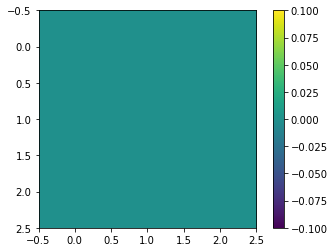

[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])]
0.0
0.0
[[[[0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]]]]


In [405]:
grad = np.gradient(expectation)
plt.imshow(grad[0]);
plt.colorbar()
plt.show()
print(grad)
print(np.amax(abs(grad[0])))
print(np.amax(abs(grad[1])))
print(np.zeros((3,2)*2))

In [301]:
x = np.vstack((beta,beta)).T
print(x)
print(x[5,1])

[[0.         0.26179939 0.52359878 0.78539816 1.04719755 0.
  0.26179939 0.52359878 0.78539816 1.04719755]
 [0.         0.26179939 0.52359878 0.78539816 1.04719755 0.
  0.26179939 0.52359878 0.78539816 1.04719755]]


IndexError: index 5 is out of bounds for axis 0 with size 2

In [323]:
depth = 2

gamma = np.zeros((depth,ngamma))
gmin = [0,2]
gmax = [3,3]

for i in range(0,depth):
    gamma[i,:] = np.linspace(gmin[i], gmax[i], ngamma)
for j in range(0,nbeta):
    beta = np.linspace(bmin, bmax/sect, nbeta)
print(gamma)

[[0.         0.33333333 0.66666667 1.         1.33333333 1.66666667
  2.         2.33333333 2.66666667 3.        ]
 [2.         2.11111111 2.22222222 2.33333333 2.44444444 2.55555556
  2.66666667 2.77777778 2.88888889 3.        ]]


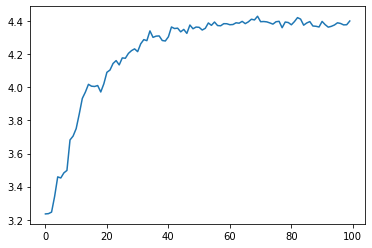

[4.392 4.378]
-0.7166666666666544
[0.45816667 0.4275     0.23166667 0.24916667]
[0.495      0.62333333 0.73716667 0.5775    ]


In [595]:
#Initializing rando variables
p = 4 #Depth
expectation = np.zeros(2)
energy = np.zeros(2**edges, dtype=int)
Delta = 0.01


#Thingy for binary thingy
s = list("{0:0eb}")
s[4] = str(edges)
binlist="".join(s)


#Amount of simulations
shots = 3000

#Calculating the energies that belong to each state. I think with a real quantum computer we could perhaps skip this.
for k in range(0,2**edges):
    y = np.array([int(x) for x in binlist.format(k)]) #btw we gotta change this part manually when we have larger graph
    energy[k] = int(np.sum(np.outer(y,(1-y)) * A))

    
    
#intialize beta (x) and gamma(y)
x = np.full(p,.5)
y = np.full(p,.5)
dx = np.zeros(p)
dy = np.zeros(p)

#Gonna use this in the loop
xnew = x
ynew = y

#Optimizer parameters. Correction is the step size we are gonna use for changing x and y
OptiRounds = 100
Expected = np.zeros(OptiRounds)
correction = 0.01


#This part looks super messy. Perhaps we could write a function that outputs the expectation value for given x and y

#This loop is for the optimization. That's why this stuff takes ages to run.
for m in range(0,OptiRounds):
    
    for l in range(0,p):

        #Find the expectation value for each point on the grid for varying beta
        for j in range(0,2):
            xnew = x
            #print(xnew)
            xnew[l] = x[l]+(-1)**j*Delta
            #print(xnew)
            mc.build_circuit(depth = p, beta = xnew, gamma = y)
            counts = mc.solve(sims=shots)
            xnew = 0
            #re-ordering
            counts = sorted(counts.items(), key = lambda x:(x[0], x[1]), reverse=True)
            counts2 = np.array(counts).astype(int)[::-1]

            #Sometimes a state gets no count. This is to preserve the dimension of the energy.
            energy2 = np.zeros(len(counts2), dtype=int)

            #Prevent energy and counts2 array not same dimensions coz counts doesn't return no count states
            for k in range(0,len(counts2)):
                energy2[k] = energy[int(str(counts2[k,0]),2)]

            #Fancy expectation
            expectation[j] = np.dot(np.array(energy2),counts2[:,1])/shots  

        #Calculate derivative at beta central difference
        dx = (expectation[0]-expectation[1])/(2*Delta)



        #Find the expectation value for each point on the grid for varying gamma
        for j in range(0,2):
            ynew = y
            ynew[l] = y[l]+(-1)**j*Delta
            mc.build_circuit(depth = p, beta = x, gamma = ynew)
            counts = mc.solve(sims=shots)
            ynew = 0
            #re-ordering
            counts = sorted(counts.items(), key = lambda x:(x[0], x[1]), reverse=True)
            counts2 = np.array(counts).astype(int)[::-1]

            #Sometimes a state gets no count. This is to preserve the dimension of the energy.
            energy2 = np.zeros(len(counts2), dtype=int)

            #Prevent energy and counts2 array not same dimensions coz counts doesn't return no count states
            for k in range(0,len(counts2)):
                energy2[k] = energy[int(str(counts2[k,0]),2)]

            #Fancy expectation
            expectation[j] = np.dot(np.array(energy2),counts2[:,1])/shots  

        #Calculate derivative at beta central difference
        dy = (expectation[0]-expectation[1])/(2*Delta)
        
        
        #Apply correction. Notice the + sign coz we have gradient ascent.
        x[l] = x[l]+correction*dx
        y[l] = y[l]+correction*dy






    #Here we output the expectation value for the corrected x and y. Just nice to see how the expectation value increases
    mc.build_circuit(depth = p, beta = x, gamma = y)
    counts = mc.solve(sims=shots)
    #re-ordering
    counts = sorted(counts.items(), key = lambda x:(x[0], x[1]), reverse=True)
    counts2 = np.array(counts).astype(int)[::-1]

    #Sometimes a state gets no count. This is to preserve the dimension of the energy.
    energy2 = np.zeros(len(counts2), dtype=int)

    #Prevent energy and counts2 array not same dimensions coz counts doesn't return no count states
    for k in range(0,len(counts2)):
        energy2[k] = energy[int(str(counts2[k,0]),2)]

    #Fancy expectation
    Expected[m] = np.dot(np.array(energy2),counts2[:,1])/shots  
    #print(Expected)
        
        
        
        
        
        
        
        
        
        
        
        
#Fancy expectation heatmap
plt.plot(Expected)
plt.show()

# #Random thingies
# print(expectation)
# print(dx)
# print(x)
# print(y)